In [44]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns

In [45]:
dateparse = lambda dates: pd.to_datetime(dates)
plt.rcParams['figure.figsize'] = [12, 6]

In [46]:
url = '../lstm/data/AAPL.csv'
dataframe = pd.read_csv(url, parse_dates=['date'], index_col='date', date_parser=dateparse)

In [47]:
df = dataframe[['closeadj','return','cumul','7days','14days']]
dates = df.index.tolist()

Start date is:  2011-01-03 00:00:00
End date is:  2021-09-08 00:00:00


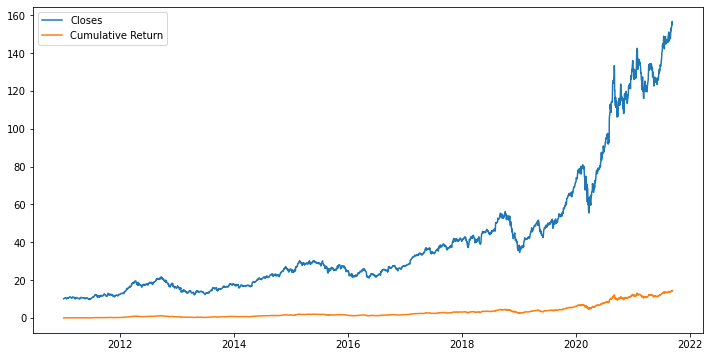

In [48]:
plt.plot(dates,df['closeadj'], label='Closes')
plt.plot(dates,df['cumul'], label='Cumulative Return')
plt.legend()
# sns.lineplot(x=dates, y=df['cumul'])
print("Start date is: ", min(dates))
print("End date is: ", max(dates))

In [49]:
df.describe()

,closeadj,return,cumul,7days,14days
count,2689.000000,2689.000000,2689.000000,2682.000000,2675.000000
mean,40.732718,0.001175,3.030947,0.008087,0.016150
std,34.341228,0.017810,3.398439,0.044816,0.063585
min,9.668000,-0.128646,-0.043246,-0.173118,-0.232823
25%,17.600000,-0.007153,0.741712,-0.018333,-0.022214
50%,27.143000,0.000897,1.686096,0.009272,0.017667
75%,46.870000,0.010367,3.638298,0.035066,0.059927
max,156.690000,0.119801,14.506185,0.221452,0.244097


In [133]:
#tEST data from end 2019....
train, test = df.loc[df.index <= '2019-12-31'], df.loc[df.index > '2019-12-31']
data = df.copy()

In [134]:
feature_col = 'closeadj'


scaler = StandardScaler()
scaler = scaler.fit(data[[feature_col]])

train[feature_col] = scaler.transform(train[[feature_col]])
test[feature_col] = scaler.transform(test[[feature_col]])
data[feature_col] = scaler.transform(data[[feature_col]])

/home/karim/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/karim/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [135]:

seq_size = 14  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[[feature_col]], train[feature_col], seq_size)
testX, testY = to_sequences(test[[feature_col]], test[feature_col], seq_size)
dataX, dataY = to_sequences(df[[feature_col]], df[feature_col], seq_size)


In [136]:
# define Autoencoder model
#Input shape would be seq_size, 1 - 1 beacuse we have 1 feature. 
# seq_size = trainX.shape[1]

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(trainX.shape[1]))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(trainX.shape[2])))

# s
#Try another model
# model = Sequential()
# model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(rate=0.2))

# model.add(RepeatVector(trainX.shape[1]))

# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(TimeDistributed(Dense(trainX.shape[2])))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 14, 128)           66560     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 14, 64)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 14, 64)            33024     
_________________________________________________________________
lstm_11 (LSTM)               (None, 14, 128)           98816     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 14, 1)             129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
________________________________________________

In [137]:
# fit model
history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_split=0.1, verbose=1, shuffle=False)

Epoch 1/20
64/64 [==============================] - 11s 102ms/step - loss: 0.1519 - val_loss: 0.1927
Epoch 2/20
64/64 [==============================] - 5s 83ms/step - loss: 0.0726 - val_loss: 0.0851
Epoch 3/20
64/64 [==============================] - 5s 78ms/step - loss: 0.0425 - val_loss: 0.1474
Epoch 4/20
64/64 [==============================] - 6s 86ms/step - loss: 0.0261 - val_loss: 0.0766
Epoch 5/20
64/64 [==============================] - 6s 88ms/step - loss: 0.0147 - val_loss: 0.0711
Epoch 6/20
64/64 [==============================] - 6s 89ms/step - loss: 0.0154 - val_loss: 0.3308
Epoch 7/20
64/64 [==============================] - 6s 87ms/step - loss: 0.0102 - val_loss: 0.1287
Epoch 8/20
64/64 [==============================] - 5s 84ms/step - loss: 0.0168 - val_loss: 0.1733
Epoch 9/20
64/64 [==============================] - 5s 85ms/step - loss: 0.0128 - val_loss: 0.1489
Epoch 10/20
64/64 [==============================] - 6s 88ms/step - loss: 0.0082 - val_loss: 0.1277
Epoch 1

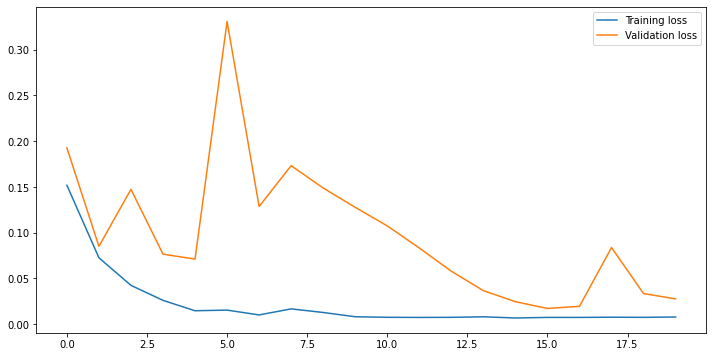

In [138]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

(array([123.,   4.,   9.,   2.,   1.,   1.,   1.,   1.,   0.,   1.,   1.,
          0.,   1.,   0.,   1.,   1.,  10.,   4.,   9.,   7.,  10.,  32.,
         33.,  23.,  25.,  45.,  30.,  15.,  14.,   7.]),
 array([ 0.14904092,  1.08946459,  2.02988825,  2.97031191,  3.91073558,
         4.85115924,  5.79158291,  6.73200657,  7.67243023,  8.6128539 ,
         9.55327756, 10.49370122, 11.43412489, 12.37454855, 13.31497221,
        14.25539588, 15.19581954, 16.13624321, 17.07666687, 18.01709053,
        18.9575142 , 19.89793786, 20.83836152, 21.77878519, 22.71920885,
        23.65963251, 24.60005618, 25.54047984, 26.48090351, 27.42132717,
        28.36175083]),
 <BarContainer object of 30 artists>)

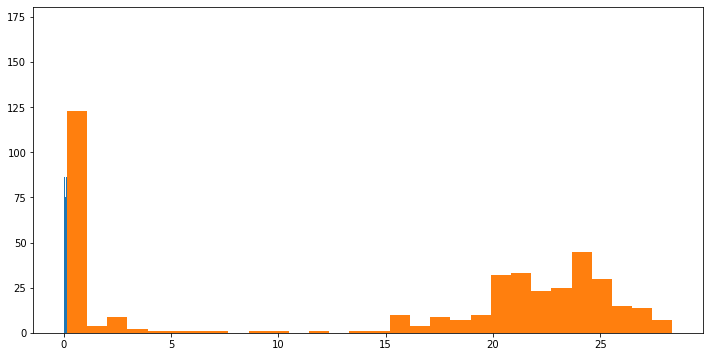

In [139]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)
max_trainMAE = max(trainMAE)[0]  #or Define 90% value of max as threshold.

testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

In [142]:
dataPredict = model.predict(dataX)
pred_dates = df.index[seq_size:data.shape[0]]

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(dataPredict, df.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

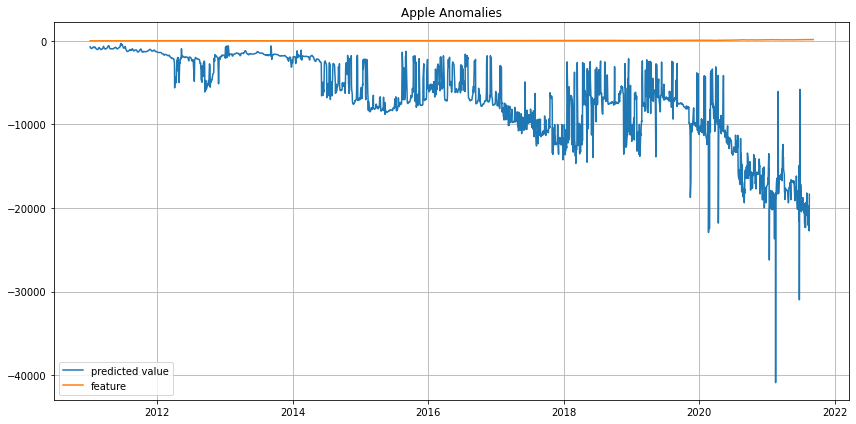

In [141]:
plt.title(label="Apple Anomalies")
plt.plot(pred_dates, y_pred_future[:,0], label="predicted value")
plt.plot(dates, df[feature_col],label='feature')

plt.legend()
# # Tweak spacing to prevent clipping of ylabel
plt.grid()
plt.tight_layout()
plt.show()

In [61]:
max_trainMAE

0.7437936901620754

In [62]:
#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df[feature_col] = test[seq_size:][feature_col]


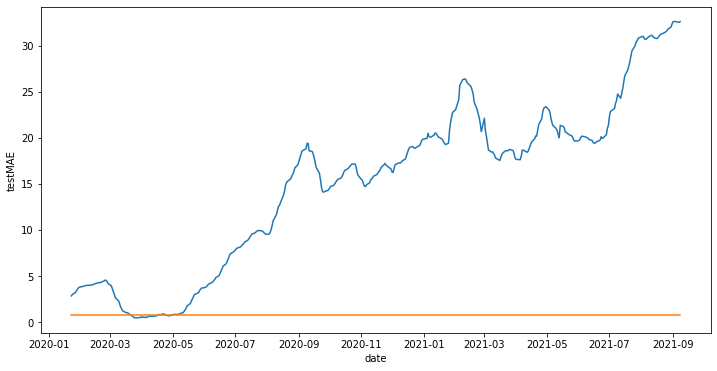

In [63]:

#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df.index, y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df.index, y=anomaly_df['max_trainMAE'])

anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]


<AxesSubplot:xlabel='date'>

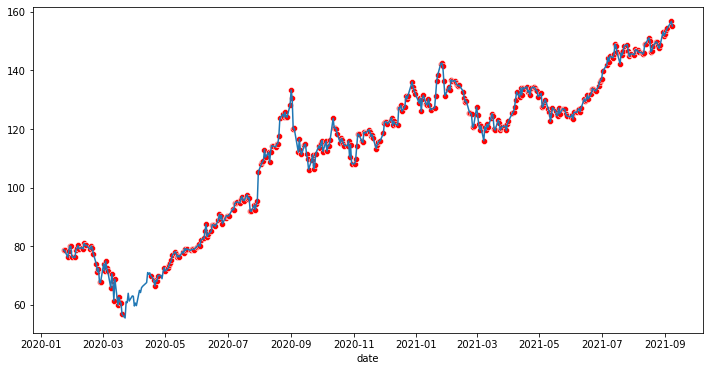

In [64]:

#Plot anomalies
sns.lineplot(x=anomaly_df.index, y=scaler.inverse_transform(anomaly_df[feature_col]))
sns.scatterplot(x=anomalies.index, y=scaler.inverse_transform(anomalies[feature_col]), color='r')